# Non-linear Component Analysis


Here, we implement a kernel PCA (Schölkopf *et al*. (1998)) that uses random Fourier features (Rahimi *et al* (2008)) or Nystroem features (Williams *et al*. (2001)). The idea is that usually a kernel cannot be computed efficiently, since it usually requires $\Omega(pn^2)$ operations, where $p$ is the dimensionality of the features and $n$ the number of observations. For large $n$ this is infeasible. If we approximate the kernel however this can be solved (somewhat) efficiently.

Here we use a Gaussian kernel, i.e. a Fourier transform the Nystroem approximations to it.

First we load some libs:

In [1]:
import sklearn
import math
import numpy
from numpy import matmul
import scipy
from scipy import linalg
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

%matplotlib inline  
import matplotlib.pyplot as plt

Next we generate random data.

In [2]:
numpy.random.seed(23)
X, y = make_circles(n_samples=400, factor=.3, noise=.05)

In [3]:
X = X - numpy.mean(X, axis=0)

Implementation of a Gaussian kernel. We can do this with `sklearn`, too, actually.

In [4]:
def rainbowfacet(x, sigma=1):
    psd = squareform(pdist(x, 'sqeuclidean'))
    K = scipy.exp(-psd / sigma ** 2)
    return K

Implementation of Nystroem kernel approximation by Williams *et al*. (2001).

In [5]:
def nystroem(K, m=10):
    idx = numpy.random.choice(K.shape[0], m, replace=False)
    K_xs = K[:, idx]
    K_ss = K[numpy.ix_(idx, idx)]
    K_hat = K_xs.dot(numpy.linalg.pinv(K_ss)).dot(K_xs.T)
    return K_hat

Implementation of random fourier features. After this we can use a normal PCA, because we model the non-linearity already with this approximation

In [6]:
def fourier(x, n_features=10):    
    w = numpy.random.normal(size=(X.shape[1], n_features))
    b = 2 * numpy.pi * numpy.random.rand(n_features)
    return numpy.sqrt(2.0 / n_features) * numpy.cos(numpy.dot(X, w) + b)

In [7]:
N, P = X.shape
n_comp = N

In [8]:
ones = numpy.ones(N)

In [9]:
ones = numpy.ones(N).reshape((N, 1))
O = matmul(ones, ones.T) / N

Next we compute the Kernel PCAs for the complete Kernel, the Fourier features and the Nystroem Kernel.

In [14]:
def kernig(K, n_comp=N):
    ones = numpy.ones(N)
    Kt = K - matmul(O, K) - matmul(K, O) + matmul(O, matmul(K, O))
    return Kt

In [15]:
def kpca(K, n_components=10):
    U, L = linalg.eigh(K)
    indices = U.argsort()[::-1]
    U, L = U[indices], L[:, indices]
    L, U = L[:, U > 0], U[U > 0]
    return numpy.dot(K, (L / numpy.sqrt(U))[:, :n_components])

In [16]:
K = rainbowfacet(X)
K_pca = kpca(kernig(rainbowfacet(X)), 10)

In [17]:
Kn_pca = kpca(kernig(nystroem(K, 10)), 10)

In [18]:
Kf_pca = PCA(10).fit_transform(fourier(X, 400))

In [19]:
print(K_pca.shape)
print(Kf_pca.shape)
print(Kn_pca.shape)

(400, 10)
(400, 10)
(400, 10)


We compare our implementations with the `sklearn` kernel PCA.

In [20]:
X_kpca = KernelPCA(kernel="rbf", gamma=1).fit_transform(X)

Finally, let's plot what we got.

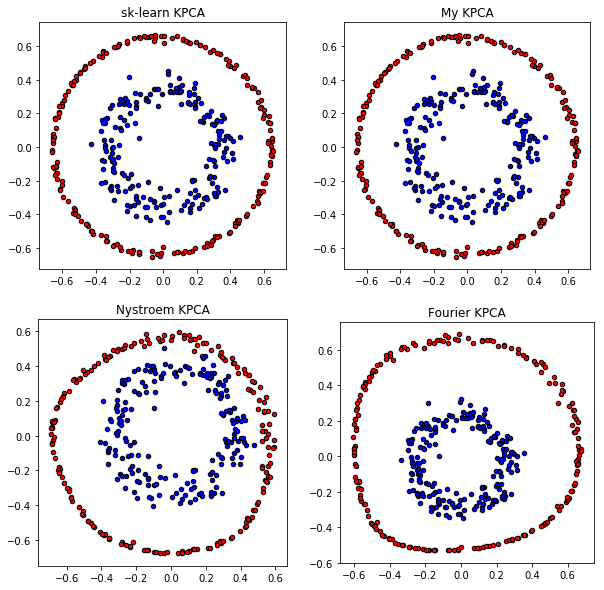

In [22]:
reds = y == 0
blues = y == 1

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1, aspect='equal')
plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue", s=20, edgecolor='k')
plt.title("sk-learn KPCA")

plt.subplot(2, 2, 2, aspect='equal')
plt.scatter(K_pca[reds, 0], K_pca[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(K_pca[blues, 0], K_pca[blues, 1], c="blue", s=20, edgecolor='k')
plt.title("My KPCA")

plt.subplot(2, 2, 3, aspect='equal')
plt.scatter(Kn_pca[reds, 0], Kn_pca[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(Kn_pca[blues, 0], Kn_pca[blues, 1], c="blue", s=20, edgecolor='k')
plt.title("Nystroem KPCA")

plt.subplot(2, 2, 4, aspect='equal')
plt.scatter(Kf_pca[reds, 0], Kf_pca[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(Kf_pca[blues, 0], Kf_pca[blues, 1], c="blue", s=20, edgecolor='k')
plt.title("Fourier KPCA")

plt.show()

Sweet! Between our kernel PCA and the one from `sklearn` is no difference at all. The Nystroem and Fourier kPCAs also seem to nicely approximate the true kPCA.